In [1]:
# --- Importing necessary libraries for data manipulation ---
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

# --- library to create and process word embeddings ---
from gensim.models import Word2Vec

# --- visuals --- 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

### 1. Processing data in Excel format

### Brief description

InvoiceNo: Invoice number, a unique number assigned to each transaction.

StockCode: Product/item code. a unique number assigned to each distinct product.

Description: Product description

Quantity: The quantities of each product per transaction.

InvoiceDate: Invoice Date and time. The day and time when each transaction was generated.

CustomerID: Customer number, a unique number assigned to each customer.

Country: Original country where the customer comes from.

In [2]:
df = pd.read_excel('../Downloads/Online Retail.xlsx')

In [52]:
# --- show first 10 records ---
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [45]:
# --- output unique values from 'Country' column ---
print(df.Country.unique())

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [56]:
# --- check how many unique countries does the dataset hold ---
len(df.Country.unique())

37

In [47]:
df.shape

(541909, 8)

In [49]:
# --- lookup missing values ---
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [50]:
# --- drop missing values ---
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [51]:
df.shape

(406829, 8)

### 2. Data preparation

In [54]:
# --- converting StockCode into String format ---
df['StockCode'] = df['StockCode'].astype(str)

In [55]:
# --- check unique customers by listing them from column to comma separated values ---
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

- There is 4,372 unique records. For each client (record) we will extract details regarding the purchase made -> coming up with 4,372 purchase samples.
- Split data into 90% train and 10% validation for word2vec model

In [57]:
# --- random shuffle of customers ---
random.shuffle(customers)

# --- 90% of client IDs using List Comprehension --- 
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# --- split data using .isin() --- 
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [58]:
# --- empty train list for purchase history ---
purchases_train = []

# --- fill the list with IDs (tqdm for progress bar) ---
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:06<00:00, 634.51it/s]


In [59]:
# --- empty validation list for purchase history ---
purchases_val = []

# --- fill the list with IDs (tqdm for progress bar) ---
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 865.51it/s]


### 3. Word2vec (w2v) model deploying with gensim lib

In [62]:
# --- train w2v model with following parameters:
# --- sliding window = 10; 
# --- skip-gram algorithm = 1; 
# --- hierarchical softmax optimization = 0; 
# --- negative sampling method = 10; 
# --- alpha (speed) = 0.03
# --- min_alpha (starting velocity) = 0.0007; 
# --- random seed = 14 ---
model = Word2Vec(window = 10, sg = 1, hs = 0, negative = 10, alpha = 0.03,
                min_alpha = 0.0007, seed = 14)

# --- create vocabulary --- 
model.build_vocab(purchases_train, progress_per = 200)

# --- training process on 10 epochs (iterations) ---
model.train(purchases_train, total_examples = model.corpus_count,
           epochs = 10, report_delay = 1)

(3632629, 3670100)

In [63]:
# --- saving model into a file with .model extension ---
model.save("word2vec_2.model")

- Negative Sampling (ng parameter) was used for averaging word vectors. The model is trained, therefore there is no need to waste our memory.
- From gensim documentation page: 
"Precompute L2-normalized vectors.
If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!"

In [65]:
model.init_sims(replace=True)
print(model)

Word2Vec(vocab=3160, size=100, alpha=0.03)


- For a robust and quick access to each word embedding let's extract it with .wv method and save.

In [66]:
X = model[model.wv.vocab]
X.shape

(3160, 100)

### 4. Visualizing w2v model

In [105]:
#!pip uninstall umap -y

Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1


In [112]:
#pip install --upgrade pip

     |████████████████████████████████| 1.5MB 640kB/s eta 0:00:01
  Found existing installation: pip 19.3
    Uninstalling pip-19.3:
      Successfully uninstalled pip-19.3
Note: you may need to restart the kernel to use updated packages.


In [115]:
#!pip install umap-learn --ignore-installed

Processing /Users/andrejlapikov/Library/Caches/pip/wheels/d0/f8/d5/8e3af3ee957feb9b403a060ebe72f7561887fef9dea658326e/umap_learn-0.3.10-cp36-none-any.whl
     |████████████████████████████████| 11.1 MB 2.8 MB/s eta 0:00:011
     |████████████████████████████████| 15.2 MB 623 kB/s eta 0:00:01
     |████████████████████████████████| 28.5 MB 883 kB/s eta 0:00:01    |█                               | 890 kB 873 kB/s eta 0:00:32     |█▉                              | 1.6 MB 719 kB/s eta 0:00:38     |███████▉                        | 7.0 MB 361 kB/s eta 0:01:00     |████████▋                       | 7.6 MB 692 kB/s eta 0:00:31     |████████▊                       | 7.8 MB 622 kB/s eta 0:00:34     |██████████▋                     | 9.4 MB 967 kB/s eta 0:00:20     |█████████████▊                  | 12.2 MB 933 kB/s eta 0:00:18     |███████████████████             | 16.9 MB 973 kB/s eta 0:00:12     |████████████████████            | 17.8 MB 1.1 MB/s eta 0:00:11     |████████████████████████▎   

In [116]:
import umap.umap_ as umap

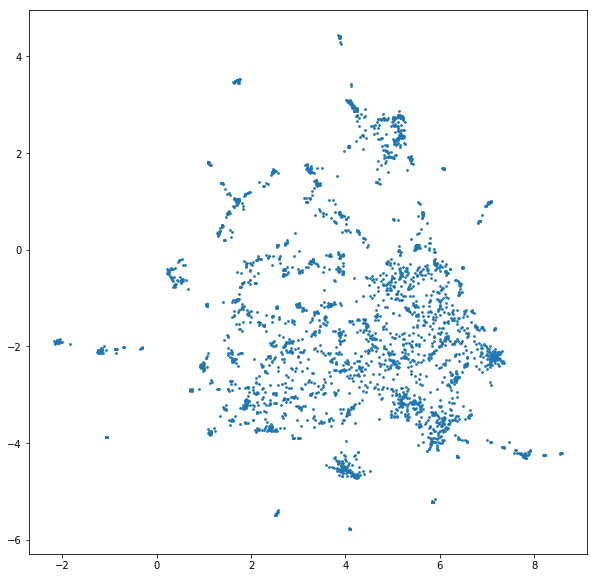

In [117]:
# --- using nearest neighbors = 30 and 2D format ---
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

# --- plotting a simple word embedding distribution Scatter Plot with matplotlib ---
plt.figure(figsize=(10,10))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s = 3, cmap = 'Spectral')

- Each separate dot on the above graph is assigned to a product. It is not hard to observe, that we have come up with a few clusters – product sets, which are close to each other in embedding space.
- Now, we are all set for creating a simple recommendation

### 5. Recommendations

In [118]:
products = train_df[["StockCode", "Description"]]

# --- drop Duplicates --- 
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# --- create "Dictionary productID" -> product_description using apply() func ---
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [119]:
# --- Check one random value by its code ---
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

- Define a function which returns top N similar goods:

In [120]:
def similar_products(v, n = 10):
    
    # --- extract most similar vector embeddings ---
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # --- title and similarity estimation ---
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        # --- adding values to list using append() method ---
        new_ms.append(pair)
        
    return new_ms

In [121]:
# --- calling a function with random ID ---
similar_products(model['90019A'])

[('AMBER DROP EARRINGS W LONG BEADS', 0.7853783965110779),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7787414789199829),
 ('FLOWER GLASS GARLD NECKL36"AMETHYST', 0.7564055919647217),
 ('GREEN MURANO TWIST BRACELET', 0.7470500469207764),
 ('JADE DROP EARRINGS W FILIGREE', 0.7357568740844727),
 ('SILVER M.O.P. ORBIT NECKLACE', 0.7334731817245483),
 ('PINK ROSEBUD PEARL BRACELET', 0.7245172262191772),
 ('SILVER ROCCOCO CHANDELIER', 0.7231802940368652),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7224634885787964),
 ('VINTAGE ROSE BEAD BRACELET RASPBERR', 0.7208513021469116)]

- Let's make our function take into account a few previous purchases.
- One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [122]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [125]:
# --- return vector dimensionality ---
aggregate_vectors(purchases_val[0]).shape

(100,)

In [126]:
similar_products(aggregate_vectors(purchases_val[0]))

[('LOVE BUILDING BLOCK WORD', 0.6786332130432129),
 ('RECIPE BOX WITH METAL HEART', 0.6613205671310425),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.6445159316062927),
 ('CREAM SWEETHEART WALL CABINET', 0.6397420763969421),
 ('BATH BUILDING BLOCK WORD', 0.6374175548553467),
 ('REGENCY CAKESTAND 3 TIER', 0.6367335319519043),
 ('FINE WICKER HEART ', 0.635863721370697),
 ('GREEN EASTER EGG HUNT START POST', 0.6344667673110962),
 ('HANGING METAL HEART LANTERN', 0.6259174346923828),
 ('DOORSTOP RETROSPOT HEART', 0.61710524559021)]